In [1]:
# Import libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams 
import cmocean 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ML
from keras.models import Sequential
from keras.layers import Dense
import keras.layers as layers
import keras
import keras_metrics
import innvestigate
import tensorflow as tf
import warnings

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Optionally, suppress warnings in general
warnings.filterwarnings("ignore")

np.random.seed(20)

Using TensorFlow backend.


### Input data 

In [2]:
# Read SST field
#tos_data = xr.open_dataset('/work/uo1075/u301680/all_member/detrend/all_detrend_ocean.nc')
tos_data = xr.open_dataset('/work/uo1075/u301680/all_member/ocean/all_ocean.nc') # trend 

# Extract North Atlantic SST
tos_north_atlantic = tos_data.sel(lat=slice(0, 80), lon=slice(265, 360))

# Calculate seasonal (quarterly) means with seasons starting in December (DJF)
tos_seasonal = tos_north_atlantic['tos'].resample(time="QS-DEC").mean()

# Select autumn seasons (September as the starting month of autumn)
#tos_autumn = tos_seasonal.sel(time=tos_seasonal.time.dt.month==9)
tos_autumn = tos_seasonal.sel(time=(tos_seasonal.time.dt.month.isin([9, 10, 11])))


# Select data from 1850 to 2013
tos_autumn = tos_autumn.sel(time=slice("1850-09-01T00:00:00.000000000", "2013-09-01T00:00:00.000000000"))

# Store the autumn SST data into input_data variable
input_data = tos_autumn

# Get the size of latitude and longitude
lat_size = input_data.lat.size
lon_size = input_data.lon.size

# Calculate time series by reshaping data
input_data_timeseries = input_data.values.reshape(input_data.shape[0]*input_data.shape[1],input_data.shape[2]*input_data.shape[3])

# Store reshaped data into input_vect
input_vect = input_data_timeseries

# print(f'shape of input vector: {input_vect.shape}')
# print(f'shape off input data: {input_data.shape}')

# Normalize the input_vect
mx = input_vect.mean(axis=0)
sx = input_vect.std(axis=0)
X_all = (input_vect - input_vect.mean(axis=0))/input_vect.std(axis=0)

# Fill any NaN values with zero 
X_all = np.where(np.isnan(X_all),0,X_all)

### Target data

In [3]:
# Read 2mT field
#tas_data = xr.open_dataset('/work/uo1075/u301680/all_member/detrend/all_detrend_land.nc') # detrend data
tas_data = xr.open_dataset('/work/uo1075/u301680/all_member/land/all.nc') # trend

# Extract Europe 2mT
#tas_europe = tas_data.sel(lat=slice(33, 79), lon=slice(-29, 40))
tas_europe = tas_data.sel(lat=slice(35, 70), lon=slice(-11, 40))

# Calculate seasonal (quarterly) means with seasons starting in December (DJF)
tas_seasonal = tas_europe['tas'].resample(time="QS-DEC").mean()

# Select winter seasons (December as the starting month of winter)
#tas_winter = tas_seasonal.sel(time=tas_seasonal.time.dt.month==12)
tas_winter = tas_seasonal.sel(time=(tas_seasonal.time.dt.month.isin([12, 1, 2])))

# Select data from 1850 to 2013
tas_winter = tas_winter.sel(time=slice("1850-12-01T00:00:00.000000000", "2013-12-01T00:00:00.000000000"))

# Store the winter 2mT data into hw_exceed variable
hw_exceed = tas_winter

# #vectorize the data
# hw_exceed_timeseries = hw_exceed.values.reshape(hw_exceed.shape[0]*hw_exceed.shape[1],hw_exceed.shape[2],hw_exceed.shape[3])

#Sum over europe
hw_exceed_europe = np.sum(hw_exceed,axis=2)
hw_exceed_europe = np.sum(hw_exceed_europe,axis=2)

#vectorize
hw_exceed_europe_timeseries = hw_exceed_europe.values.reshape(-1)

# # Calculate the sample mean
# sample_mean = hw_exceed_europe_timeseries.mean()

# index_sort = np.argsort(hw_exceed_europe_timeseries)

# threshold_index = np.searchsorted(hw_exceed_europe_timeseries[index_sort], sample_mean)

# classification = np.zeros(len(index_sort), dtype=int)

# classification[index_sort[threshold_index:]] = 1

# Y_all = keras.utils.to_categorical(classification)

# #print("Classification array:", classification)
# print(Y_all.shape)

# Calculate the sample mean
sample_mean = hw_exceed_europe_timeseries.mean()

# Classify data: 1 for values greater than or equal to the mean, 0 for values below the mean
classification = (hw_exceed_europe_timeseries >= sample_mean).astype(int)

# One-hot encoding for Keras
Y_all = keras.utils.to_categorical(classification)

In [4]:
# Summing over axis 0 to count the number of occurrences of each class
counts = np.sum(Y_all, axis=0)

print(f"Number of samples for class 0: {counts[0]}")
print(f"Number of samples for class 1: {counts[1]}")

Number of samples for class 0: 3949.0
Number of samples for class 1: 4251.0


### ML part

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(X_all, Y_all, test_size=0.2, random_state=1)

#Calculate the number of inputs
number_inputs = X_train.shape[-1]
#Calculate number of classes
num_classes = len(np.unique(classification))
# Seed
seed_number = 55 

#Nodes
number_nodes_layer_one = 10 #number of nodes of layer one
#number_nodes_layer_two = 5 #number of nodes of layer two (needed if layer two exists)

#Regularization
l1_regularization_layer_one = 0
l2_regularization_layer_one = 2 #regularization to avoid overfitting, higher the value, less overfit, more underfit 

# l1_regularization_layer_two = 0
# l2_regularization_layer_two = 0

l1_regularization_layer_three = 0
l2_regularization_layer_three = 0

#Best: 0.5573143362998962 using {'optimizer': 'sgd', 'learning_rate': 1e-05, 'epochs': 200, 'batch_size': 16, 'activation': 'elu'}
# Best: 0.5585347612698873 using {'optimizer': 'sgd', 'learning_rate': 0.0001, 'epochs': 200, 'batch_size': 64, 'activation': 'relu'}
#Best: 0.5589918891588846 using {'optimizer': 'adam', 'learning_rate': 0.0001, 'epochs': 50, 'batch_size': 32, 'activation': 'relu'}
#Learning rate
learning_rate = 0.0001
batch_size = 32
epochs = 50
shuffle = True
verbose = 2 #(0 = no output; 2 = output accuracy every epoch)


model = keras.models.Sequential([ \

    keras.layers.Dense(number_nodes_layer_one, input_shape=(int(number_inputs),), 
                       use_bias=True, activation='relu',
                        kernel_initializer=keras.initializers.he_normal(seed=seed_number), bias_initializer=keras.initializers.zeros(),
                        kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_one, l2=l2_regularization_layer_one)),
    #keras.layers.BatchNormalization(),
       
    #keras.layers.Dense(number_nodes_layer_two, activation='sigmoid', use_bias=True,
    #                   kernel_initializer=keras.initializers.glorot_normal(seed=seed_number), bias_initializer=keras.initializers.he_normal(seed=seed_number), 
    #                   kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_two, l2=l2_regularization_layer_two)),
          
    keras.layers.Dense(num_classes, use_bias=True, 
                       kernel_initializer=keras.initializers.he_normal(seed=seed_number), bias_initializer=keras.initializers.zeros(), 
                       kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_three, l2=l2_regularization_layer_three)),
    #keras.layers.BatchNormalization(),

    keras.layers.Activation('softmax') 
                      ])   

    
#opt = keras.optimizers.SGD(lr=learning_rate, momentum=0.01, nesterov=False, decay=0)
opt = keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=opt,
              loss = 'categorical_crossentropy', 
              metrics=[keras.metrics.categorical_accuracy, keras_metrics.precision(), keras_metrics.recall(),
                      keras_metrics.f1_score()])


#Early Stop
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)]

# Train the neural network!
#class_weight = {0: 1.0, 1: 2.0} 
class_weight = {0: 1.01, 1: 0.95}


history = model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), 
      batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose 
      ,callbacks=callback, class_weight=class_weight)

Train on 6560 samples, validate on 1640 samples
Epoch 1/50
 - 0s - loss: 25.5844 - categorical_accuracy: 0.5500 - precision: 0.5386 - recall: 0.4485 - f1_score: 0.4894 - val_loss: 14.3781 - val_categorical_accuracy: 0.5872 - val_precision: 0.5827 - val_recall: 0.5189 - val_f1_score: 0.5490
Epoch 2/50
 - 0s - loss: 8.9101 - categorical_accuracy: 0.5840 - precision: 0.5677 - recall: 0.5664 - f1_score: 0.5670 - val_loss: 5.0385 - val_categorical_accuracy: 0.6116 - val_precision: 0.5961 - val_recall: 0.6134 - val_f1_score: 0.6046
Epoch 3/50
 - 0s - loss: 3.2051 - categorical_accuracy: 0.5941 - precision: 0.5699 - recall: 0.6358 - f1_score: 0.6010 - val_loss: 1.9394 - val_categorical_accuracy: 0.6110 - val_precision: 0.5890 - val_recall: 0.6499 - val_f1_score: 0.6180
Epoch 4/50
 - 0s - loss: 1.3664 - categorical_accuracy: 0.6063 - precision: 0.5781 - recall: 0.6707 - f1_score: 0.6210 - val_loss: 0.9877 - val_categorical_accuracy: 0.6018 - val_precision: 0.5784 - val_recall: 0.6549 - val_f1_

In [6]:
# import numpy as np
# from sklearn.model_selection import RandomizedSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
# import tensorflow as tf
# from tensorflow import keras

# def build_model(activation='relu', optimizer='adam', learning_rate=0.01):
#     model = keras.models.Sequential([
#         keras.layers.Dense(10, input_shape=(number_inputs,), 
#                            activation=activation,
#                            kernel_initializer=keras.initializers.he_normal(seed=seed_number),
#                            kernel_regularizer=keras.regularizers.l2(l2_regularization_layer_one)),
        
#         keras.layers.Dense(num_classes, activation='softmax', 
#                            kernel_initializer=keras.initializers.he_normal(seed=seed_number))
#     ])

#     if optimizer == 'sgd':
#         opt = keras.optimizers.SGD(lr=learning_rate, momentum=0.01)
#     elif optimizer == 'adam':
#         opt = keras.optimizers.Adam(lr=learning_rate)
#     elif optimizer == 'rmsprop':
#         opt = keras.optimizers.RMSprop(lr=learning_rate)
#     else:
#         opt = keras.optimizers.Adam(lr=learning_rate)  # default

#     model.compile(optimizer=opt,
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# param_dist = {
#     'batch_size': [16, 32, 64, 128],
#     'epochs': [50, 100, 200, 300],
#     'activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu', 'elu', 'swish'],
#     'optimizer': ['adam', 'sgd', 'rmsprop'],
#     'learning_rate': [0.0001, 0.001, 0.01, 0.1]
# }

# model1 = KerasClassifier(build_fn=build_model, verbose=0)

# random_search = RandomizedSearchCV(estimator=model1, 
#                                    param_distributions=param_dist, 
#                                    n_iter=10,  # Number of parameter settings sampled
#                                    cv=3,  # 3-fold cross-validation
#                                    verbose=2, 
#                                    n_jobs=-1)  # Use all available cores

# random_search_result = random_search.fit(X_train, Y_train)

# print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")


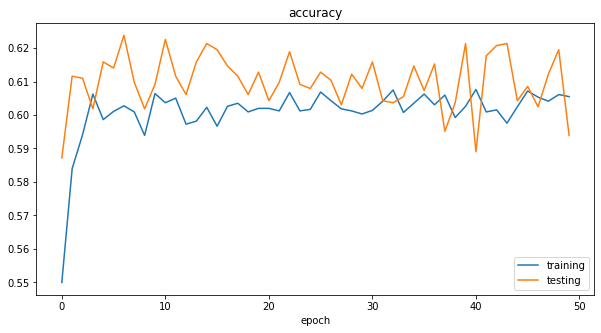

In [7]:
# Plot Accuracy graph
plt.figure(figsize=(10,5))
plt.plot(history.history['categorical_accuracy'],label = 'training')
plt.plot(history.history['val_categorical_accuracy'], label = 'testing')
plt.title('accuracy')
plt.xlabel('epoch')
# plt.xticks(epoch_label)
plt.legend()
plt.show()

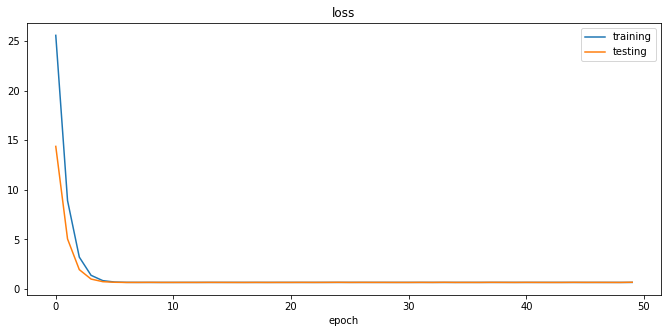

In [8]:
# Plot loss curve
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.title('loss')
plt.xlabel('epoch')
#plt.xticks(epoch_label)
plt.legend()
plt.show()

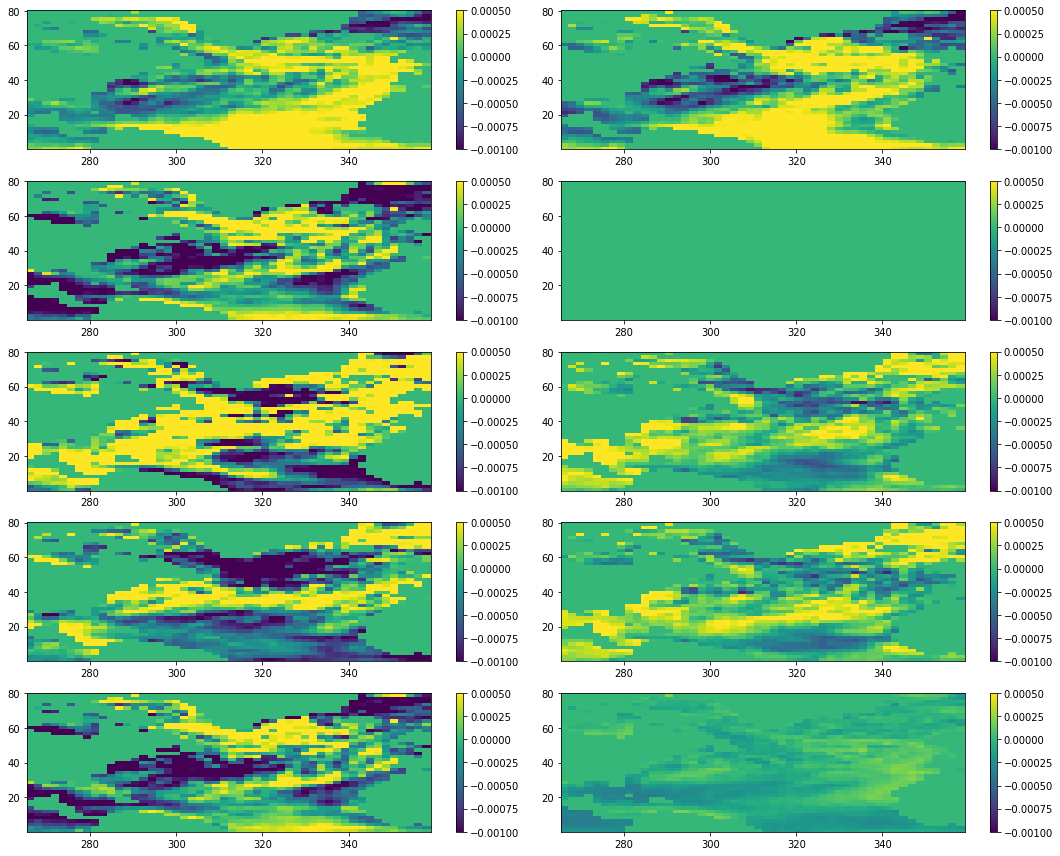

In [9]:
# plot weights
layer_weights, layer_biases = model.layers[0].get_weights()
layers_1 = layer_weights.T
layers_1 = layers_1.reshape(layers_1.shape[0], lat_size, lon_size)

rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

# plot the weights for each neuron
for i in range(layers_1.shape[0]):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    c = ax.pcolormesh(tos_autumn.lon, tos_autumn.lat, layers_1[i,:,:], shading='auto', vmin=-0.0010, vmax=0.0005, cmap='viridis')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
model_probability = model.predict(X_validation)

y_predict_all = np.zeros((model_probability.shape[0],model_probability.shape[1]))
for i in range(model_probability.shape[0]):
    y_predict_all[i,:] = (model_probability[i,:] == np.max(model_probability[i,:])).astype(np.int)

cm = confusion_matrix(Y_validation.argmax(axis=1), y_predict_all.argmax(axis=1))
print(cm)

[[515 279]
 [387 459]]


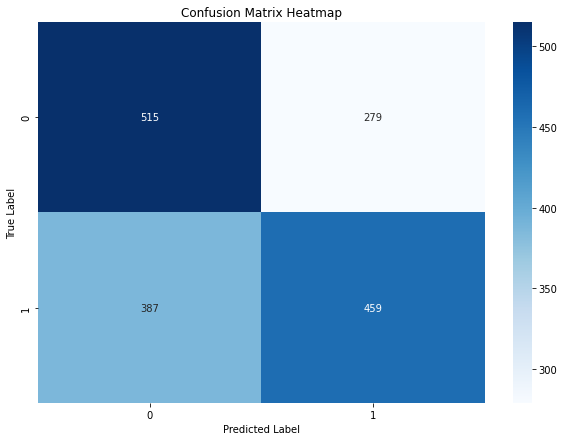

In [11]:
# Plotting the heatmap
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=np.arange(cm.shape[1]), 
            yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

### Layer-wise Relevence Propagation (LRP) & SST pattern

In [12]:
model_nosoftmax = innvestigate.utils.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer('lrp.z', model_nosoftmax)
#analyzer = innvestigate.create_analyzer('lrp.epsilon', model_nosoftmax)
#analyzer = innvestigate.create_analyzer('deep_taylor', model_nosoftmax)

sst_tp_cl1 = []
sst_tp_cl2 = []

LRP_heatmaps_tp_cl1 = []
LRP_heatmaps_tp_cl2 = []

for sample_ind, sample in enumerate(X_validation):          
    if (Y_validation[sample_ind,0] == 1)&(y_predict_all[sample_ind,0]==1):
        sst_tp_cl1.append(sample[np.newaxis,...])
        
        LRP_heatmap = analyzer.analyze(sample[np.newaxis,...])
        LRP_heatmaps_tp_cl1.append(LRP_heatmap)
        
    if (Y_validation[sample_ind,1] == 1)&(y_predict_all[sample_ind,1]==1):
        sst_tp_cl2.append(sample[np.newaxis,...])
        LRP_heatmap = analyzer.analyze(sample[np.newaxis,...])
        LRP_heatmaps_tp_cl2.append(LRP_heatmap)



In [13]:
# print(LRP_heatmaps_tp_cl1.shape)
# print(LRP_heatmaps_tp_cl2.shape)

In [14]:
# Lrp heatmaps for true negative and positive class
LRP_heatmaps_tp_cl1 = np.array(LRP_heatmaps_tp_cl1) # True negative class
LRP_heatmaps_tp_cl2 = np.array(LRP_heatmaps_tp_cl2) # True positive class

# Normalize Lrp
LRP_heatmaps_tp_cl1 = LRP_heatmaps_tp_cl1/np.max(LRP_heatmaps_tp_cl1, axis=(-2,-1))[:,np.newaxis,np.newaxis]
LRP_heatmaps_tp_cl2 = LRP_heatmaps_tp_cl2/np.max(LRP_heatmaps_tp_cl2, axis=(-2,-1))[:,np.newaxis,np.newaxis]

# insert lat/lon dimensions to convert the vectorized file into the original grid!
LRP_heatmaps_tp_cl1 = LRP_heatmaps_tp_cl1.reshape(LRP_heatmaps_tp_cl1.shape[0], lat_size, lon_size)
LRP_heatmaps_tp_cl2 = LRP_heatmaps_tp_cl2.reshape(LRP_heatmaps_tp_cl2.shape[0], lat_size, lon_size)

# Comppsite of heatmap
LRP_heatmaps_tp_cl1_mean = np.nanmean(LRP_heatmaps_tp_cl1, axis=0)
LRP_heatmaps_tp_cl2_mean = np.nanmean(LRP_heatmaps_tp_cl2, axis=0)

LRP_heatmaps_tp_mean = np.zeros((2,LRP_heatmaps_tp_cl1_mean.shape[0],LRP_heatmaps_tp_cl1_mean.shape[1]))

LRP_heatmaps_tp_mean[0,:,:] = LRP_heatmaps_tp_cl1_mean
LRP_heatmaps_tp_mean[1,:,:] = LRP_heatmaps_tp_cl2_mean

LRP_heatmaps_tp_mean = np.where(LRP_heatmaps_tp_mean==0,np.nan,LRP_heatmaps_tp_mean)

In [15]:
print(LRP_heatmaps_tp_mean.shape)

(2, 43, 50)


In [16]:
# SST pattern for true negative and positive class

sst_tp_cl1 = np.array(sst_tp_cl1)
sst_tp_cl2 = np.array(sst_tp_cl2)

sst_tp_cl1_ice = sst_tp_cl1.reshape(sst_tp_cl1.shape[0], lat_size, lon_size)
sst_tp_cl2_ice = sst_tp_cl2.reshape(sst_tp_cl2.shape[0], lat_size, lon_size)

# Composite of pattern
sst_tp_cl1_mean = np.nanmean(sst_tp_cl1_ice, axis=0)
sst_tp_cl2_mean = np.nanmean(sst_tp_cl2_ice, axis=0)

sst_tp_mean = np.zeros((2,sst_tp_cl1_mean.shape[0],sst_tp_cl1_mean.shape[1]))

sst_tp_mean[0,:,:] = sst_tp_cl1_mean
sst_tp_mean[1,:,:] = sst_tp_cl2_mean

sst_tp_mean = np.where(sst_tp_mean==0,np.nan,sst_tp_mean)

### Plot pattern and heatmap

0
1


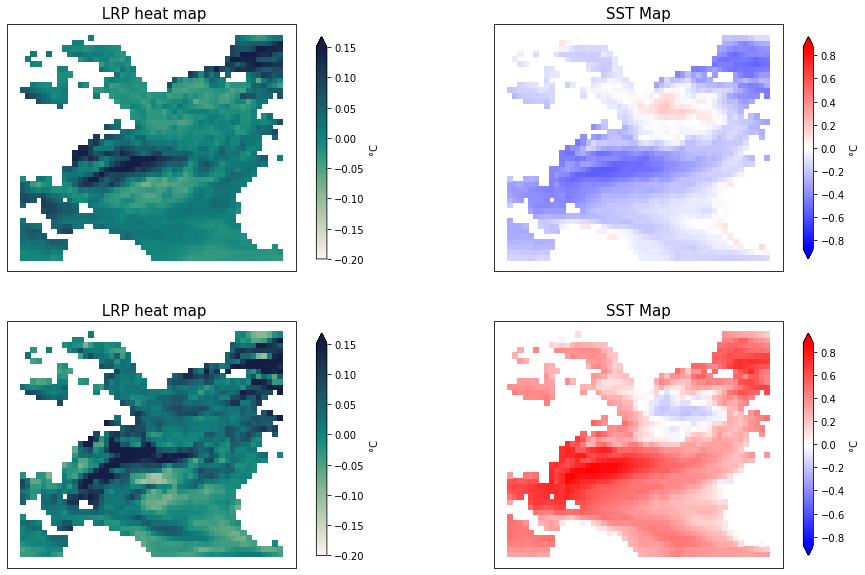

In [17]:
s=0.9
fig = plt.figure(figsize=(16,10))
rows = 2
columns = 2

for i in range(LRP_heatmaps_tp_mean.shape[0]):
    print(i)
    ii = i*columns+1
    ax = fig.add_subplot(rows,columns,ii, projection=ccrs.PlateCarree())
    
    plt.pcolormesh(tos_autumn.lon,tos_autumn.lat,LRP_heatmaps_tp_mean[i,:,:], cmap=cmocean.cm.tempo, shading='auto', vmin=-.2, vmax=0.15)
    ax.set_title(' LRP heat map',fontsize = 15)
    #ax.coastlines()
    cbar = plt.colorbar(shrink=s,extend='max')
    cbar.set_label(label='°C', size=10)
    cbar.ax.tick_params(labelsize=10) 
    
    ax = fig.add_subplot(rows,columns,ii+1, projection=ccrs.PlateCarree())
    plt.pcolormesh(tos_autumn.lon,tos_autumn.lat,sst_tp_mean[i,:,:], cmap=plt.cm.get_cmap('bwr'), shading='auto', vmin=-np.nanmax(np.abs(sst_tp_mean[:,:,:])),vmax=np.nanmax(np.abs(sst_tp_mean[:,:,:])))
    ax.set_title(f'SST Map', fontsize=15)
    cbar = plt.colorbar(shrink=s,extend='both')
    cbar.set_label(label='°C', size=10)
    cbar.ax.tick_params(labelsize=10) 
    # ax.coastlines()
    # plt.savefig("c.png")

In [18]:
# # 1. Identify correctly classified samples for class 1 (i.e., where class == 1)
# correct_class_1_indices = np.where((np.argmax(Y_validation, axis=1) == np.argmax(y_predict_all, axis=1)) & 
#                                    (np.argmax(Y_validation, axis=1) == 1))[0]  # Correctly classified class 1 samples

# # Make sure the indices don't exceed the time steps available in tos_autumn
# correct_class_1_indices = correct_class_1_indices[correct_class_1_indices < tas_winter.sizes['time']]

# # Initialize an array to accumulate the SST values for all correctly classified samples
# sst_composite = np.zeros_like(tas_winter.isel(time=0).values[0, :, :])  # Assuming the first level is depth (if any)

# # 2. Accumulate SST values for correctly classified samples
# for idx in correct_class_1_indices:
    
#     # Extract the SST values for the corresponding time step
#     sst_spatial = tas_winter.isel(time=idx).values
    
#     # Ensure SST data is 2D by selecting only the surface level (if a depth dimension exists)
#     if sst_spatial.ndim == 3:
#         sst_spatial = sst_spatial[0, :, :]  # Assuming the first dimension is depth; adjust if necessary
    
#     # Accumulate the SST values
#     sst_composite += sst_spatial

# # 3. Calculate the mean SST (composite) by dividing by the number of samples
# sst_composite /= len(correct_class_1_indices)

# # 4. Plot the composite SST values spatially over a map
# plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Create a plot of the composite SST values
# im = ax.pcolormesh(tas_winter.lon, tas_winter.lat, sst_composite, cmap='plasma', transform=ccrs.PlateCarree())

# # Add coastlines and gridlines
# #ax.coastlines()
# #ax.gridlines(draw_labels=True)

# # Add a color bar for SST
# cbar = plt.colorbar(im, shrink= 1, extend='max', pad=0.05)
# cbar.set_label(label='°C', size=10)

# # Title the plot as the composite SST
# plt.title('SAT of Correctly Classified Class 1 Samples')

# plt.show()

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

# # Assume tos_autumn and other variables are already defined

# # Extract indices for correctly classified class 0 samples
# correct_class_0_indices = np.where((np.argmax(Y_validation, axis=1) == np.argmax(y_predict_all, axis=1)) & 
#                                    (np.argmax(Y_validation, axis=1) == 0))[0]

# # Ensure the indices are within bounds
# correct_class_0_indices = correct_class_0_indices[correct_class_0_indices < tas_winter.sizes['time']]

# # Initialize the array to accumulate SST values for class 0
# sst_composite_class_0 = np.zeros_like(tas_winter.isel(time=0).values[0, :, :])

# # Accumulate SST values
# for idx in correct_class_0_indices:
#     sst_spatial = tas_winter.isel(time=idx).values
#     if sst_spatial.ndim == 3:
#         sst_spatial = sst_spatial[0, :, :]  # Take the surface level if a depth dimension exists
#     sst_composite_class_0 += sst_spatial

# # Calculate the mean SST (composite) by dividing by the number of samples
# sst_composite_class_0 /= len(correct_class_0_indices)

# # # # Standardize the composite SST (zero mean and unit standard deviation)
# # mean_sst = np.mean(sst_composite_class_0)
# # std_sst = np.std(sst_composite_class_0)
# # sst_composite_class_0_standardized = (sst_composite_class_0 - mean_sst) / std_sst

# # # Replace NaN values with 0
# # sst_composite_class_0_standardized = np.nan_to_num(sst_composite_class_0_standardized)

# # Plot the standardized composite SST values using pcolormesh
# plt.figure(figsize=(10, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Create a plot of the standardized composite SST values using pcolormesh
# im = ax.pcolormesh(tas_winter.lon, tas_winter.lat, sst_composite_class_0, cmap='plasma', transform=ccrs.PlateCarree())

# # Add coastlines and gridlines
# # ax.coastlines()
# # ax.gridlines(draw_labels=True)

# # Add a color bar for SST
# cbar= plt.colorbar(im, shrink= 1, extend='max', pad=0.05)
# cbar.set_label(label='°C', size=10)

# # Title the plot as the composite SST for class 0
# plt.title('SST of Correctly Classified Class 0 Samples')

# plt.show()